In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip '/content/drive/MyDrive/ResearchWork_2023/cropped_images_zip/cropped_training_images.zip'

Archive:  /content/drive/MyDrive/ResearchWork_2023/cropped_images_zip/cropped_training_images.zip
replace cropped_training_images/0_left.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace cropped_training_images/0_left.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: None


In [ ]:
# Load the pre-trained Inception-ResNet-V2 model
base_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(250,250,3))

# Freeze the pre-trained weights
base_model.trainable = False

# Define the input shape
input_shape = (250, 250, 3)

# Define the input layer
# inputs = tf.keras.layers.Input(shape=input_shape)

# Pass the input layer through the pre-trained model
features = base_model.output

# Add a dense layer for multi-class classification
# outputs = tf.keras.layers.Dense(units=8, activation='sigmoid')(features)

outputs = tf.keras.layers.Flatten()(features)
outputs = tf.keras.layers.Dense(units=8, activation='sigmoid')(outputs)

In [ ]:
!pip install tensorflow_addons
import tensorflow_addons as tfa
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
f1_score = tfa.metrics.F1Score(num_classes=8
                               )


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Create the model
model = tf.keras.Model(inputs=base_model.input, outputs=outputs)
# Compile the model
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
               loss='binary_crossentropy',
              metrics=['accuracy', precision , recall, f1_score])

In [ ]:
model.summary()


In [ ]:
# Load the image data and one-hot encoded multi-label data
# Load the data from the excel sheet into a pandas dataframe
# Load both left and right eye dataset
# base_path = 'C:/Users/User/DeepLearning/DL-Project'
# left_df = pd.read_excel(f'{base_path}/updated_left_eye.xlsx')
# right_df = pd.read_excel(f'{base_path}/updated_right_eye.xlsx')

# #concating both dataframes
# df = pd.concat([left_df, right_df], axis=0)


# # Split the data into two arrays, one for the image paths and one for the labels
# images_base_path = 'E:/odir-dataset/ODIR-5K/ODIR-5K/cropped_training_images/'
# image_paths = images_base_path + df["Fundus"].values
# labels = df.iloc[:, 3:].values

# # Convert the lists to tensors
# image_paths = tf.constant(image_paths)
# labels = tf.constant(labels)

# # Create a dataset from the image paths and labels
# dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

In [ ]:
# Load the image data and one-hot encoded multi-label data
# Load the data from the excel sheet into a pandas dataframe
# Load both left and right eye dataset
base_path = '/content/drive/MyDrive/ResearchWork_2023'
left_df = pd.read_excel(f'{base_path}/updated_left_eye.xlsx')
right_df = pd.read_excel(f'{base_path}/updated_right_eye.xlsx')

#concating both dataframes
df = pd.concat([left_df, right_df], axis=0)


# Split the data into two arrays, one for the image paths and one for the labels
images_base_path = '/content/cropped_training_images/'
image_paths = images_base_path + df["Fundus"].values
labels = df.iloc[:, 3:].values

# Convert the lists to tensors
image_paths = tf.constant(image_paths)
labels = tf.constant(labels)

# Create a dataset from the image paths and labels
dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

In [ ]:
# Load the images and preprocess them
def load_and_preprocess_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [250, 250])
    image = tf.keras.applications.inception_resnet_v2.preprocess_input(image)
    return image, label

# Apply the load_and_preprocess_image function to the dataset
dataset = dataset.map(load_and_preprocess_image)

# Shuffle the data and batch it
batch_size = 64
dataset = dataset.shuffle(buffer_size=len(image_paths)).batch(batch_size)

In [ ]:
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.int64, name=None))>

In [ ]:
def split_data(dataset, train_split, test_split, val_split):
    # Calculate the size of each split
    dataset_size = dataset.reduce(tf.constant(0, dtype=tf.int64), lambda acc, _: acc + 1).numpy()
    train_size = int(dataset_size * train_split)
    val_size = int(dataset_size * val_split)
    test_size = int(dataset_size * test_split)

    # Shuffle the elements of the dataset randomly
    dataset = dataset.shuffle(buffer_size=dataset_size, seed=42)

    # Split the dataset into train, validation, and test sets
    train_dataset = dataset.take(train_size)
    remaining_dataset = dataset.skip(train_size)
    val_dataset = remaining_dataset.take(val_size)
    test_dataset = remaining_dataset.skip(val_size)
    return train_dataset, test_dataset, val_dataset

In [ ]:
# Split the data into training and validation sets
train_dataset, test_dataset, val_dataset = split_data(dataset, train_split=0.7, test_split=0.15, val_split=0.15)

In [ ]:
# Train the model
history=model.fit(train_dataset, epochs=50, batch_size=batch_size, validation_data=test_dataset)

Epoch 1/50
76/76 [==============================] - 123s 967ms/step - loss: 0.3878 - accuracy: 0.3554 - precision: 0.2998 - recall: 0.2072 - f1_score: 0.1237 - val_loss: 0.3262 - val_accuracy: 0.4072 - val_precision: 0.4530 - val_recall: 0.2101 - val_f1_score: 0.1824
Epoch 2/50
76/76 [==============================] - 96s 876ms/step - loss: 0.3118 - accuracy: 0.4448 - precision: 0.4957 - recall: 0.2319 - f1_score: 0.2251 - val_loss: 0.3005 - val_accuracy: 0.4623 - val_precision: 0.4992 - val_recall: 0.2774 - val_f1_score: 0.2507
Epoch 3/50
76/76 [==============================] - 95s 877ms/step - loss: 0.2946 - accuracy: 0.4842 - precision: 0.5534 - recall: 0.2704 - f1_score: 0.2909 - val_loss: 0.2951 - val_accuracy: 0.4769 - val_precision: 0.5629 - val_recall: 0.2204 - val_f1_score: 0.3212
Epoch 4/50
76/76 [==============================] - 95s 879ms/step - loss: 0.2844 - accuracy: 0.5109 - precision: 0.5803 - recall: 0.2906 - f1_score: 0.3196 - val_loss: 0.2788 - val_accuracy: 0.5389

In [ ]:
model.save('/content/drive/MyDrive/ResearchWork_2023/models/model_2_v3.h5')

In [ ]:
import matplotlib.pyplot as plt

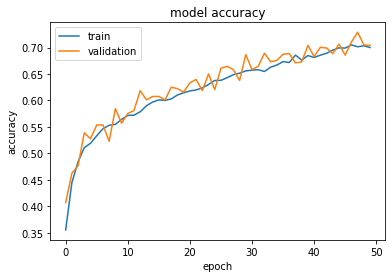

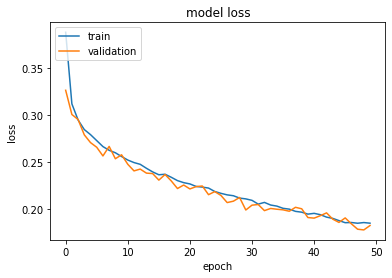

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/ResearchWork_2023/models/model_2_v3.h5')

In [ ]:
base_learning_rate = 0.00001
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
               loss='binary_crossentropy',
              metrics=['accuracy', precision , recall, f1_score])

In [ ]:
new_history=new_model.fit(train_dataset, epochs=50, batch_size=batch_size, validation_data=test_dataset)

Epoch 1/50
76/76 [==============================] - 109s 917ms/step - loss: 0.1821 - accuracy: 0.7152 - precision: 0.8125 - recall: 0.5412 - f1_score: 0.6575 - val_loss: 0.1775 - val_accuracy: 0.7463 - val_precision: 0.8495 - val_recall: 0.5211 - val_f1_score: 0.7087
Epoch 2/50
76/76 [==============================] - 94s 875ms/step - loss: 0.1796 - accuracy: 0.7183 - precision: 0.8071 - recall: 0.5492 - f1_score: 0.6606 - val_loss: 0.1781 - val_accuracy: 0.7325 - val_precision: 0.8519 - val_recall: 0.5341 - val_f1_score: 0.7005
Epoch 3/50
76/76 [==============================] - 94s 873ms/step - loss: 0.1792 - accuracy: 0.7162 - precision: 0.8077 - recall: 0.5587 - f1_score: 0.6737 - val_loss: 0.1777 - val_accuracy: 0.7279 - val_precision: 0.8306 - val_recall: 0.5626 - val_f1_score: 0.6798
Epoch 4/50
76/76 [==============================] - 93s 873ms/step - loss: 0.1754 - accuracy: 0.7311 - precision: 0.8195 - recall: 0.5665 - f1_score: 0.6819 - val_loss: 0.1764 - val_accuracy: 0.7261

In [ ]:
model.save('/content/drive/MyDrive/ResearchWork_2023/models/model_2_v5.h5')

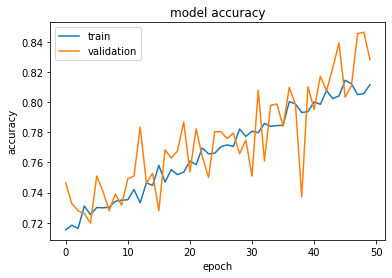

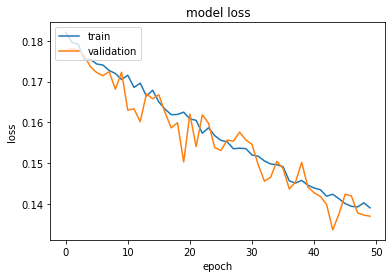

In [ ]:
plt.plot(new_history.history['accuracy'])
plt.plot(new_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(new_history.history['loss'])
plt.plot(new_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
new_model_2 = tf.keras.models.load_model('/content/drive/MyDrive/ResearchWork_2023/models/model_2_v7.h5')

In [ ]:
base_learning_rate = 0.00001
new_model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
               loss='binary_crossentropy',
              metrics=['accuracy', precision , recall, f1_score])

In [ ]:
base_model.output

<KerasTensor: shape=(None, 6, 6, 1536) dtype=float32 (created by layer 'conv_7b_ac')>

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 124, 124, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_203 (Batch  (None, 124, 124, 32  96         ['conv2d_203[0][0]']             
 Normalization)                 )                                                             